In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
### 1. Events
events = pd.read_csv('/content/gdrive/MyDrive/ACT1_FIFA22/events.csv')
### 2. Ginf
ginf = pd.read_csv('/content/gdrive/MyDrive/ACT1_FIFA22/ginf.csv')

# Cargar el archivo completo
dict_df = pd.read_csv('/content/gdrive/MyDrive/ACT1_FIFA22/dictionary.txt', sep='\t')



El f´utbol es uno de los deportes m´as populares a nivel mundial, y
recientemente ha habido un auge en el an´alisis de datos para optimizar el
rendimiento de los equipos. Un jugador de f´utbol cuenta con diferentes
caracter´ısticas que lo hacen ´unico, entre ellas se encuentran la posici´on, la
velocidad, la resistencia, la t´ecnica, la precisi´on de pase, la capacidad de
remate, entre otros.
La problem´atica es encontrar un equipo titular de 11 jugadores que cumpla
con las siguientes caracter´ısticas:
1. Que el equipo tenga un balance entre jugadores ofensivos, defensivos
y de mediocampo.
2. Que el equipo tenga un balance entre habilidades t´ecnicas y f´ısicas
para garantizar un juego completo

In [ ]:
!pip install kmapper scikit-learn persim matplotlib pandas numpy ripser

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import kmapper as km

# 1. Cargar datos
events = pd.read_csv('/content/gdrive/MyDrive/ACT1_FIFA22/events.csv')

# 2. Ingeniería de características adaptada a tus columnas
def calculate_real_features(df):
    # Agregaciones usando nombres reales de columnas
    features = df.groupby('player').agg(
        tackles=('event_type', lambda x: (x == 3).sum()),        # Foul = 3
        interceptions=('event_type', lambda x: (x == 4).sum()),  # Yellow card = 4
        shots=('event_type', lambda x: (x == 1).sum()),          # Attempt = 1
        goals=('is_goal', 'sum'),
        assists=('assist_method', lambda x: x.notna().sum()),
        key_passes=('event_type2', lambda x: (x == 12).sum()),  # Key Pass = 12
        total_passes=('event_type2', lambda x: (x == 12).sum())
    ).reset_index()

    # Cálculo preciso de precisión de pases usando assist_method
    successful_passes = df[
        (df['event_type2'] == 12) &
        (df['assist_method'].notna())
    ].groupby('player').size().reset_index(name='successful_passes')

    features = pd.merge(features, successful_passes, on='player', how='left')
    features['pass_accuracy'] = features['successful_passes'] / features['total_passes']
    features['pass_accuracy'] = features['pass_accuracy'].fillna(0)

    # Métricas compuestas
    features['defensive_score'] = features['tackles'] * 0.6 + features['interceptions'] * 0.4
    features['offensive_score'] = features['goals'] * 0.5 + features['shots'] * 0.3 + features['assists'] * 0.2
    features['creative_score'] = features['key_passes'] * 0.7 + features['pass_accuracy'] * 0.3

    return features

# 3. Aplicar ingeniería de características
player_features = calculate_real_features(events)

# 4. Preparación de datos
num_cols = ['defensive_score', 'offensive_score', 'creative_score']
X = player_features[num_cols].values

# 5. Imputación y escalado
X_imputed = SimpleImputer(strategy='median').fit_transform(X)
X_scaled = StandardScaler().fit_transform(X_imputed)

# 6. Reducción dimensional y KeplerMapper
mapper = km.KeplerMapper(verbose=1)
projected = PCA(n_components=2).fit_transform(X_scaled)
graph = mapper.map(projected, clusterer=DBSCAN(eps=0.15, min_samples=6))

# 7. Visualización interactiva
mapper.visualize(
    graph,
    path_html="fifa_analysis.html",
    title="Análisis FIFA - Jugadores",
    custom_tooltips=player_features['player']
)

# 8. Sistema de selección mejorado con estadísticas justificativas
def select_team_balanced(
    features,
    formation=(4,4,2),
    tech_weights=(0.4, 0.5, 0.7)   # (peso_defensas, peso_mediocampistas, peso_delanteros)
):
    # Candidatos
    defenders  = features.nlargest(15, 'defensive_score').copy()
    midfielders= features.nlargest(15, 'creative_score').copy()
    forwards   = features.nlargest(10, 'offensive_score').copy()

    # unpack de pesos
    w_def, w_mid, w_fwd = tech_weights

    def get_best_balanced(df, n, tech_weight):
        df = df.copy()
        df['combined_score'] = tech_weight * df['creative_score'] + \
                               (1 - tech_weight) * df['defensive_score']
        return df.nlargest(n, 'combined_score')[[
            'player','combined_score','defensive_score',
            'creative_score','offensive_score'
        ]]

    # 1) Defensas
    sel_def = get_best_balanced(defenders, formation[0], tech_weight=w_def)
    usados = set(sel_def['player'])
    # filtro en los demás
    midfielders = midfielders[~midfielders['player'].isin(usados)]
    forwards    = forwards   [~forwards   ['player'].isin(usados)]

    # 2) Mediocampistas
    sel_mid = get_best_balanced(midfielders, formation[1], tech_weight=w_mid)
    usados |= set(sel_mid['player'])
    forwards = forwards[~forwards['player'].isin(usados)]

    # 3) Delanteros
    sel_fwd = get_best_balanced(forwards, formation[2], tech_weight=w_fwd)

    return {
        'Defensas': sel_def,
        'Mediocampistas': sel_mid,
        'Delanteros': sel_fwd
    }


# 9. Selección final con impresión de estadísticas
equipo_stats = select_team_balanced(player_features)
print("\nEquipo Balanceado con Estadísticas Justificativas:")
for pos, df_stats in equipo_stats.items():
    print(f"\n{pos}:")
    for _, row in df_stats.iterrows():
        print(f"- {row['player']}: combined_score={row['combined_score']:.2f}, "
              f"defensive_score={row['defensive_score']:.2f}, "
              f"creative_score={row['creative_score']:.2f}, "
              f"offensive_score={row['offensive_score']:.2f}")

KeplerMapper(verbose=1)
Mapping on data shaped (6118, 2) using lens shaped (6118, 2)

Creating 100 hypercubes.

Created 15 edges and 19 nodes in 0:00:00.195634.
Wrote visualization to: fifa_analysis.html

Equipo Balanceado con Estadísticas Justificativas:

Defensas:
- roberto firmino: combined_score=207.96, defensive_score=189.60, creative_score=235.50, offensive_score=359.90
- stefan kiessling: combined_score=200.72, defensive_score=190.60, creative_score=215.90, offensive_score=400.40
- raul garcia: combined_score=199.88, defensive_score=203.20, creative_score=194.90, offensive_score=340.80
- radja nainggolan: combined_score=195.04, defensive_score=197.00, creative_score=192.10, offensive_score=343.40

Mediocampistas:
- cristiano ronaldo: combined_score=337.25, defensive_score=70.80, creative_score=603.70, offensive_score=830.40
- robert lewandowski: combined_score=264.20, defensive_score=149.40, creative_score=379.00, offensive_score=531.90
- zlatan ibrahimovic: combined_score=250.4

In [ ]:
# Énfasis ofensivo (peso a ofensiva)
equipo_ofensivo = select_team_balanced(
    player_features,
    formation=(3,5,2),
    tech_weights=(0.4, 0.5, 0.7)
)

# Énfasis defensivo (peso a defensas y mediocampistas)
equipo_defensivo = select_team_balanced(
    player_features,
    formation=(3,5,2),
    tech_weights=(0.2, 0.4, 0.7)
)

# Énfasis medio (peso técnico en mediocampistas)
equipo_medio = select_team_balanced(
    player_features,
    formation=(3,5,2),
    tech_weights=(0.4, 0.8, 0.7)
)

# Imprimimos cada uno
for etiqueta, equipo in [
    ("Ofensivo", equipo_ofensivo),
    ("Defensivo", equipo_defensivo),
    ("Medio",     equipo_medio)
]:
    print(f"\n--- Énfasis {etiqueta} ---")
    for pos, df_stats in equipo.items():
        print(f"\n{pos}:")
        for _, row in df_stats.iterrows():
            print(f"- {row['player']}: combined={row['combined_score']:.2f}, "
                  f"def={row['defensive_score']:.2f}, "
                  f"crea={row['creative_score']:.2f}, "
                  f"off={row['offensive_score']:.2f}")



--- Énfasis Ofensivo ---

Defensas:
- roberto firmino: combined=207.96, def=189.60, crea=235.50, off=359.90
- stefan kiessling: combined=200.72, def=190.60, crea=215.90, off=400.40
- raul garcia: combined=199.88, def=203.20, crea=194.90, off=340.80

Mediocampistas:
- cristiano ronaldo: combined=337.25, def=70.80, crea=603.70, off=830.40
- robert lewandowski: combined=264.20, def=149.40, crea=379.00, off=531.90
- zlatan ibrahimovic: combined=250.40, def=159.60, crea=341.20, off=608.70
- lionel messi: combined=235.35, def=47.60, crea=423.10, off=670.30
- edinson cavani: combined=215.00, def=91.60, crea=338.40, off=479.40

Delanteros:
- pierreemerick aubameyang: combined=262.89, def=91.60, crea=336.30, off=430.00
- gonzalo higuain: combined=247.70, def=101.40, crea=310.40, off=439.40

--- Énfasis Defensivo ---

Defensas:
- perparim hetemaj: combined=220.32, def=258.00, crea=69.60, off=276.20
- gabi: combined=203.14, def=240.20, crea=54.90, off=219.00
- raul garcia: combined=201.54, def=2

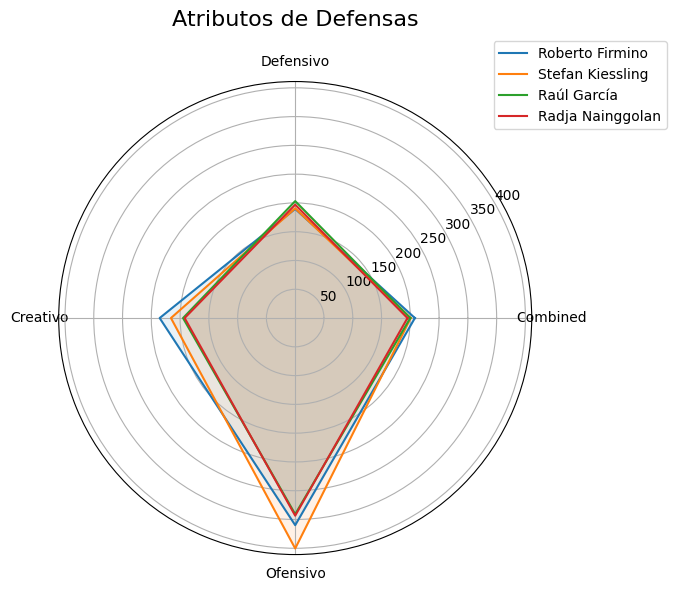

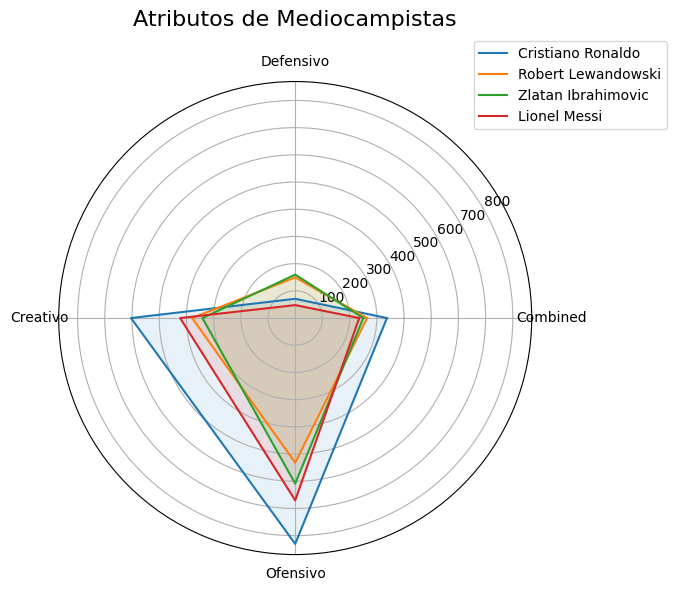

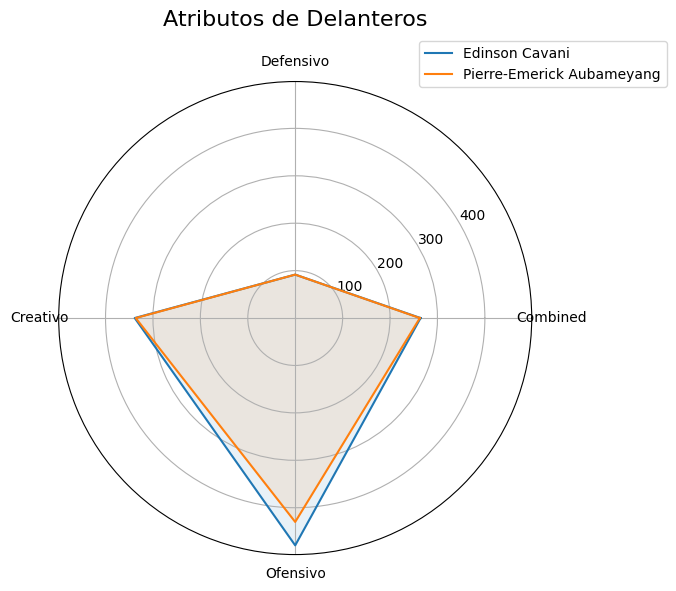

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de jugadores organizados por grupo
jugadores = {
    "Defensas": {
        "Roberto Firmino": [207.96, 189.60, 235.50, 359.90],
        "Stefan Kiessling": [200.72, 190.60, 215.90, 400.40],
        "Raúl García": [199.88, 203.20, 194.90, 340.80],
        "Radja Nainggolan": [195.04, 197.00, 192.10, 343.40]
    },
    "Mediocampistas": {
        "Cristiano Ronaldo": [337.25, 70.80, 603.70, 830.40],
        "Robert Lewandowski": [264.20, 149.40, 379.00, 531.90],
        "Zlatan Ibrahimovic": [250.40, 159.60, 341.20, 608.70],
        "Lionel Messi": [235.35, 47.60, 423.10, 670.30]
    },
    "Delanteros": {
        "Edinson Cavani": [264.36, 91.60, 338.40, 479.40],
        "Pierre-Emerick Aubameyang": [262.89, 91.60, 336.30, 430.00]
    }
}

# Etiquetas de los ejes
atributos = ['Combined', 'Defensivo', 'Creativo', 'Ofensivo']
N = len(atributos)

# Ángulos para el gráfico radar
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # cerrar el círculo

def radar_chart(jugadores_dict, titulo):
    plt.figure(figsize=(8, 6))
    ax = plt.subplot(111, polar=True)

    for nombre, valores in jugadores_dict.items():
        data = valores + valores[:1]  # cerrar el gráfico
        ax.plot(angles, data, label=nombre)
        ax.fill(angles, data, alpha=0.1)

    ax.set_title(titulo, size=16, y=1.1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(atributos)
    ax.set_rlabel_position(30)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()

# Generar los tres gráficos
for grupo, datos in jugadores.items():
    radar_chart(datos, f"Atributos de {grupo}")
